## Considerations for Classification
Here we have written down some fundamental considerations that have to be made for our given classification problem. 

#### Small, imbalanced dataset
https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
- The dataset is quite small, which means that we cannot allow ourselves to split it up in multiple pieces for training, testing and validation. We will consider a 0.9/0.1 proportion of split of training and validation set. Within the 90% of training, we will use k-fold cross-validation to see how the model performs on unseen data before feeding it the validation set (the truly unseen data).
- It is imbalanced. 
- Performance Metric : consider another peformance metric than accuracy (F1 score, for example) and confusion matrices to manually investigate the outputs and see if the model truly learned something, or if it is simply reflecting the underlying distribution of data (i.e. the class imbalance just makes it predict the most common class to achieve a good result, which we do not want). 
- Resampling data : We can oversample or undersample our data (add or remove samples from respectively the smaller and larger classes) to achieve a better balance. Because we have little data in our case, oversampling is probably the best option. It may lead to over-fitting, though. If we use over-sampling, it should be carried out as a step AFTER cross-validation partitioning, to avoid over-fitting as much as possible.
- Penalised model : we can penalise the model more if it misclassifies the minority classes. It should however be inverstigated whether this is possible for a problem with many minority classes. This should be added in the cost function estimates, but we need to find out how to do this for a PyTorch neural network. 

#### Current Pipeline : 
1. Pull lightcurves for ZTF sources from Alerce, get classes from TNS
2. Interpolate the data and merge all lightcurves in a single array
3. One-hot encode labels
4. Create training and test sets (proportions 90%/10%)
5. Use K-fold cross validation for model training
6. Over-sample the minority classes in each fold from the training set

On K-fold cross-validation implementation in PyTorch : 

https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/#summary-and-code-example-k-fold-cross-validation-with-pytorch

#### Input to RNN
- The RNN has no information about the time, so we need to feed it an array containing the lightcurve magnitude data points for each source. Ideally, the "timestep" (that it does not know) should be the same between each point, so that the RNN sees a data point for a source every X minutes/hours/days in all cases. This is an important pre-processing step for our problem.

## Import Packages and Data

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from ENID.interpolation import label_encoding
from ENID.DOClassify import network_train, network_evaluation

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

import random
random.seed(1)

In [2]:
#datafile = 'Data/FluxNormalisedColourRatio1_3Detect/data_lc.npy'
#labelsfile = 'Data/FluxNormalisedColourRatio1_3Detect/labels.npy'

datafile = 'Data/FluxNormalisedColourRatio1_5Detect/data_lc.npy'
labelsfile = 'Data/FluxNormalisedColourRatio1_5Detect/labels.npy'

data = np.load(datafile)
labels = np.load(labelsfile)

print('Data Dimensions :', data.shape)
print('Label Dimensions :', labels.shape)

Data Dimensions : (4428, 2, 200)
Label Dimensions : (4428, 2)


## Prepare for Training
### Output Information
Filenames are ordered as follows:

**ModelName_Modes_HU%%IT##**

ModelName : Information about the NN structure
- GRU : Gated Recurrent Unit
- GRUbi : Bi-directional Gated Recurrent Unit
- GRU2 : Two Gated Recurrent Units 

Modes : Information about training conditions
- Pen : Class penalty applied for under-represented classes

HU : Number of hidden units (given by %%)

IT : Iteration number of given model (given by ##)

### Partitioning and One-Hot Encoding 
We ignore the TDEs for the moment. These events are associated with a -1 label. 

We keep 10% of the entire data set as a test set to evaluate model generalisation after training. 

One-hot encoding is performed for the labels. 

In [3]:
# Standardise Data
#data = StandardScaler().fit_transform(data)
y = np.array([int(labels[i,1]) for i in range(labels.shape[0])])

# Filter out TDEs
idx = np.where(y >= 0)[0]
Y = torch.tensor(y[idx])
X = torch.permute(torch.tensor(data[idx]), [0,2,1])

# Check that the proportion of each class is roughly the same in the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
W = [1/count for count in np.unique(Y_train, return_counts=True)[1]]
W = W / min(W)
W = [int(element) for element in W]

print('Unique Labels :', np.unique(Y_train, return_counts=True)[0])
print('Training Label Proportions : ', np.unique(Y_train, return_counts=True)[1])
print('Test Label Proportions : ', np.unique(Y_test, return_counts=True)[1])
print('Estimated Class Weights : ', W, '\n')

# One-Hot Encoding
Y = label_encoding(Y).float()

# Final partitioning of the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print('Training Data Dimensions :', X_train.shape)
print('Training Label Dimensions :', Y_train.shape, '\n')

print('Test Data Dimensions :', X_test.shape)
print('Test Label Dimensions :', Y_test.shape, '\n')

Unique Labels : [0 1 2 3 4 5]
Training Label Proportions :  [ 113  722 2673   64  167  217]
Test Label Proportions :  [ 16  70 298   9  25  22]
Estimated Class Weights :  [23, 3, 1, 41, 16, 12] 

Training Data Dimensions : torch.Size([3956, 200, 2])
Training Label Dimensions : torch.Size([3956, 6]) 

Test Data Dimensions : torch.Size([440, 200, 2])
Test Label Dimensions : torch.Size([440, 6]) 



## Model Definition

### Model Class Definitions

In [8]:
class simple_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(simple_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=False) 
        self.Dense = nn.Linear(hidden_dim, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU(x)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_
    
class bi_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, n_layers):
        super(bi_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.n_layers = n_layers
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True) 
        self.Dense = nn.Linear(2*hidden_dim, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU(x)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_
    
class rapid_ENID(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, n_layers):
        super(rapid_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.GRU1 = nn.GRU(input_dim, hidden_dim1, n_layers, batch_first=True, bidirectional=False) 
        self.GRU2 = nn.GRU(hidden_dim1, hidden_dim2, n_layers, batch_first=True, bidirectional=False) 
        self.Dropout = nn.Dropout(p=0.2)
        self.Dense = nn.Linear(hidden_dim2, output_dim)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x_, h_ = self.GRU1(x)
        x_ = self.Dropout(x_)
        x_, h_ = self.GRU2(x_)
        x_ = self.Dropout(x_)
        x_ = self.Dense(x_[:,-1])
        x_ = self.predict(x_)
        
        return x_

class sexy_ENID(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, conv_out1, conv_out2, kernel1, kernel2):
        super(sexy_ENID, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.channels1 = conv_out1
        self.channels2 = conv_out2
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.conv1_out = 200 - 2*(self.kernel1 - 1)
        self.conv2_out = self.conv1_out - 2 * (self.kernel2 - 1)
        
        self.GRU = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=False) 
        
        self.Conv1 = nn.Conv1d(in_channels=2, out_channels=conv_out1, kernel_size=kernel1)
        self.Conv2 = nn.Conv1d(in_channels=conv_out1, out_channels=conv_out2, kernel_size=kernel2)
        self.Dense1_conv = nn.Linear(190, hidden_dim)
        #self.Dense2_conv = nn.Linear(out1_conv, out2_conv)
        self.relu = nn.ReLU()
        
        #self.DenseGRU = nn.Linear(hidden_dim, out_GRU)
        
        self.Dense = nn.Linear(2*hidden_dim, output_dim)
        self.Dropout = nn.Dropout(p=0.2)
        self.predict = nn.Softmax(dim=1)
        
    def forward(self, x):
        x_GRU, h_ = self.GRU(x)
        x_GRU = self.Dropout(x_GRU)
        #x_GRU = self.Dense(x_GRU[:,-1])
        
        x_ = torch.permute(x, (0,2,1))
        x_conv = self.Conv1(x_)
        x_conv = self.relu(x_conv)
        x_conv = self.Conv2(x_conv)
        x_conv = self.relu(x_conv)
        x_conv = self.Dropout(x_conv)
        x_conv = self.Dense1_conv(x_conv)
        x_conv = self.Dropout(x_conv)
        
        x_ENID = torch.cat((x_GRU, x_conv), dim=2)
        
        x_ENID = self.Dense(x_ENID[:,-1])
        x_ENID = self.predict(x_ENID)
        
        return x_ENID

### Model Building

#### GRU32 + Convolution

In [10]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 32
n_layers = 1
conv_out1 = 100
conv_out2 = 200
kernel1=9
kernel2=3

Net = sexy_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers, conv_out1=conv_out1, conv_out2=conv_out2, kernel1=kernel1, kernel2=kernel2)
print(Net)

# Initialisation
version_name = 'GRUconv_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

sexy_ENID(
  (GRU): GRU(2, 64, batch_first=True)
  (Conv1): Conv1d(2, 100, kernel_size=(9,), stride=(1,))
  (Conv2): Conv1d(100, 200, kernel_size=(3,), stride=(1,))
  (Dense1_conv): Linear(in_features=190, out_features=64, bias=True)
  (relu): ReLU()
  (Dense): Linear(in_features=128, out_features=6, bias=True)
  (Dropout): Dropout(p=0.2, inplace=False)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 6.98075
Epoch: 5, loss: 7.33897
Epoch: 10, loss: 7.33710
Epoch: 15, loss: 7.35525
Epoch: 20, loss: 6.74972
Epoch: 25, loss: 6.43676
Epoch: 30, loss: 6.41343
Epoch: 35, loss: 6.39576


KeyboardInterrupt: 

#### GRU64 + Convolution

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1
conv_out1 = 100
conv_out2 = 200
kernel1=9
kernel2=3

Net = sexy_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers, conv_out1=conv_out1, conv_out2=conv_out2, kernel1=kernel1, kernel2=kernel2)
print(Net)

# Initialisation
version_name = 'GRUconv_Pen_5_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Simple GRU32

simple_ENID(
  (GRU): GRU(2, 64, batch_first=True)
  (Dense): Linear(in_features=64, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 6.94592
Epoch: 5, loss: 6.25703
Epoch: 10, loss: 6.10453
Epoch: 15, loss: 5.89514
Epoch: 20, loss: 5.88836
Epoch: 25, loss: 5.76772
Epoch: 30, loss: 5.70479
Epoch: 35, loss: 5.80005
Epoch: 40, loss: 5.68490
Epoch: 45, loss: 5.69343
Epoch: 50, loss: 5.67013
Epoch: 55, loss: 5.70943
Epoch: 60, loss: 5.68282
Epoch: 65, loss: 5.55189
Epoch: 69, Nice, loss: 5.53396
Epoch: 70, loss: 5.49580
Epoch: 75, loss: 5.46483
Epoch: 80, loss: 5.76994
Epoch: 85, loss: 5.71025
Epoch: 90, loss: 5.82118
Epoch: 95, loss: 5.67495
Epoch: 100, loss: 6.00280
Epoch: 105, loss: 5.61349
Epoch: 110, loss: 5.62433
Epoch: 115, loss: 5.51806
Epoch: 120, loss: 5.44435
Epoch: 125, loss: 5.87419
Epoch: 130, loss: 5.82357
Epoch: 135, loss: 5.58073
Epoch: 140, loss: 5.51776
Epoch: 145, loss: 5.58893
Epoch: 150, loss: 5.68867
Epoch: 155, loss: 6.33265
Epoch: 160, loss:

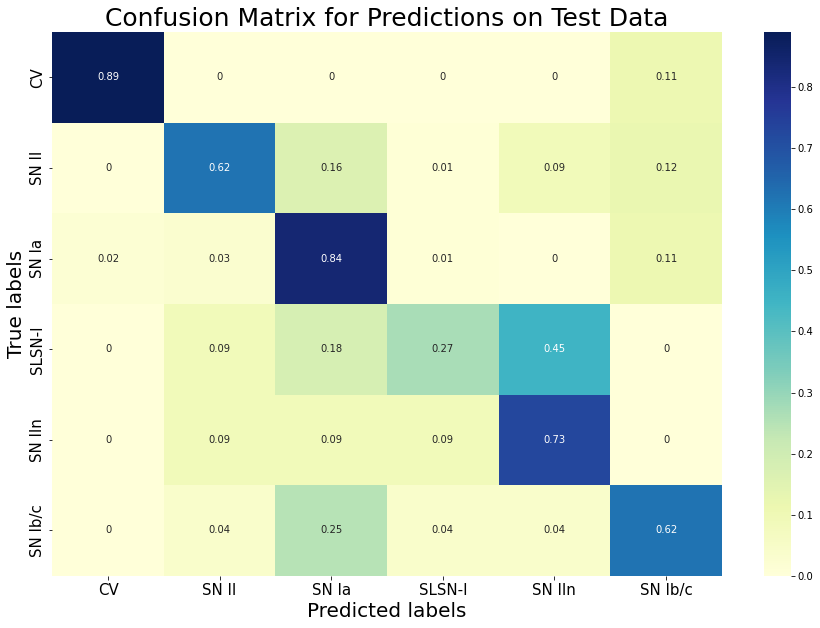

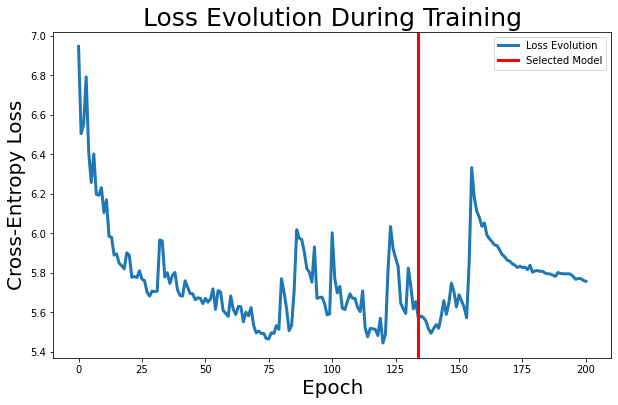

In [5]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 32
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Simple GRU64

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_5_HU64BZ256EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Simple GRU64 BZ256

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_5_HU64BZ256EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 256
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Simple GRU128

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 128
n_layers = 1

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRU_Pen_5_HU128BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU32x32

rapid_ENID(
  (GRU1): GRU(2, 64, batch_first=True)
  (GRU2): GRU(64, 64, batch_first=True)
  (Dropout): Dropout(p=0.2, inplace=False)
  (Dense): Linear(in_features=64, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 7.11560
Epoch: 5, loss: 6.85706
Epoch: 10, loss: 6.44449
Epoch: 15, loss: 6.30135
Epoch: 20, loss: 6.23980
Epoch: 25, loss: 6.21011
Epoch: 30, loss: 6.08361
Epoch: 35, loss: 6.21428
Epoch: 40, loss: 6.23299
Epoch: 45, loss: 6.31288
Epoch: 50, loss: 6.77159
Epoch: 55, loss: 6.59810
Epoch: 60, loss: 6.38763
Epoch: 65, loss: 6.39806
Epoch: 69, Nice, loss: 6.50781
Epoch: 70, loss: 6.49982
Epoch: 75, loss: 6.42775
Epoch: 80, loss: 6.42506
Epoch: 85, loss: 6.33735
Epoch: 90, loss: 6.44014
Epoch: 95, loss: 6.40267
Epoch: 100, loss: 6.36129
Epoch: 105, loss: 6.34208
Epoch: 110, loss: 6.31955
Epoch: 115, loss: 6.32633
Epoch: 120, loss: 6.28346
Epoch: 125, loss: 6.30024
Epoch: 130, loss: 6.40137
Epoch: 135, loss: 6.29112
Epoch: 140, loss: 6.24272
Epoch: 145, 

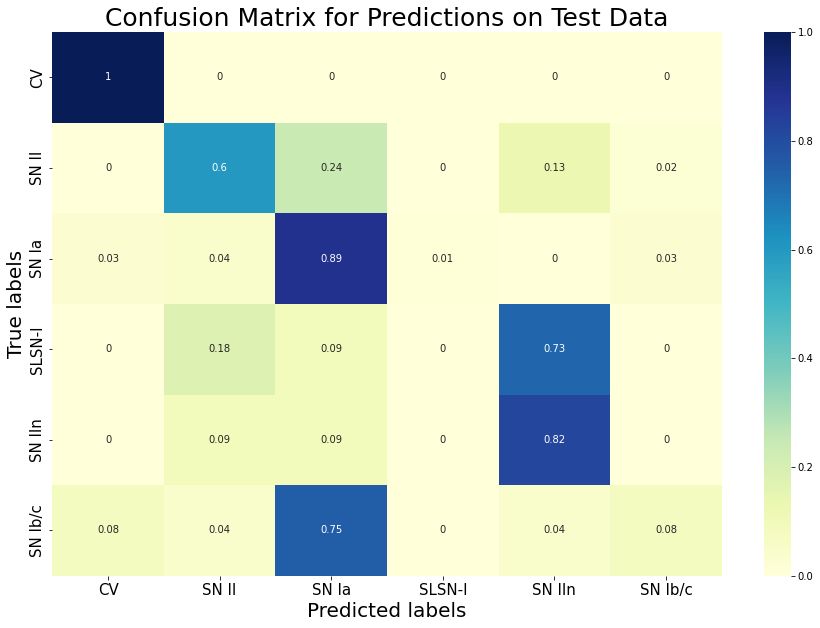

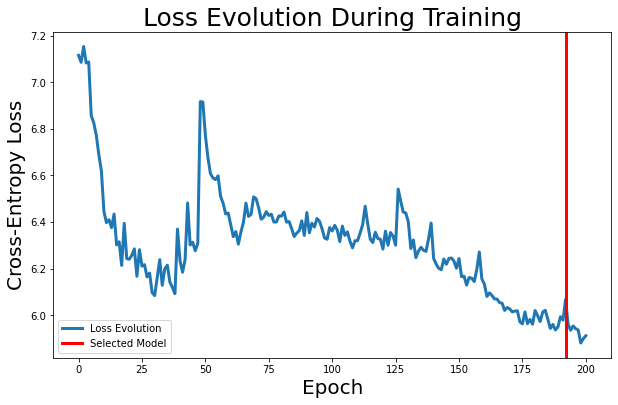

In [9]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 32
hidden_dim2 = 32
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU32x64

rapid_ENID(
  (GRU1): GRU(2, 64, batch_first=True)
  (GRU2): GRU(64, 128, batch_first=True)
  (Dropout): Dropout(p=0.2, inplace=False)
  (Dense): Linear(in_features=128, out_features=6, bias=True)
  (predict): Softmax(dim=1)
)
Epoch: 0, loss: 7.12522
Epoch: 5, loss: 6.59239
Epoch: 10, loss: 6.75912
Epoch: 15, loss: 6.74639
Epoch: 20, loss: 6.79384
Epoch: 25, loss: 6.75994
Epoch: 30, loss: 6.76228
Epoch: 35, loss: 6.72248
Epoch: 40, loss: 6.71405
Epoch: 45, loss: 6.73443
Epoch: 50, loss: 6.76065
Epoch: 55, loss: 6.60437
Epoch: 60, loss: 6.45814
Epoch: 65, loss: 6.39257
Epoch: 69, Nice, loss: 6.40871
Epoch: 70, loss: 6.35583
Epoch: 75, loss: 6.29989
Epoch: 80, loss: 6.29539
Epoch: 85, loss: 6.31140
Epoch: 90, loss: 6.27364
Epoch: 95, loss: 6.28653
Epoch: 100, loss: 6.28635
Epoch: 105, loss: 6.22568
Epoch: 110, loss: 6.25102
Epoch: 115, loss: 6.23662
Epoch: 120, loss: 6.25115
Epoch: 125, loss: 6.29817
Epoch: 130, loss: 6.31008
Epoch: 135, loss: 6.24680
Epoch: 140, loss: 6.26215
Epoch: 145

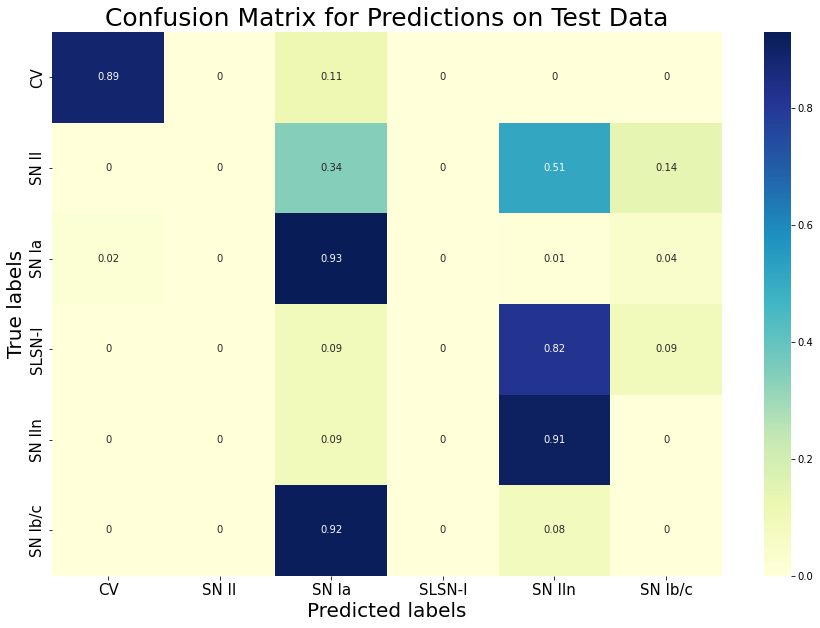

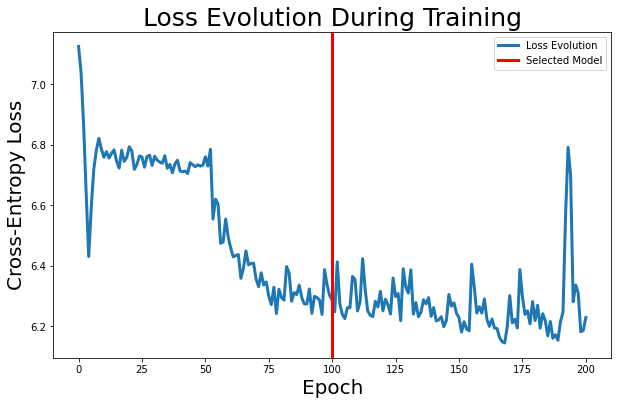

In [11]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 32
hidden_dim2 = 64
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU3264BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU64x32

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 64
hidden_dim2 = 32
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU3264BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU64x64

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 64
hidden_dim2 = 64
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_5_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Bi-directional GRU32

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 32
n_layers = 1

Net = bi_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRUbi_Pen_5_HU32BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Bi-directional GRU64

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1

Net = bi_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRUbi_Pen_5_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

## Back-up Example

input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 32
n_layers = 1

print('Number of Classes :', num_classes, '\n')

Net = simple_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

version_name = 'LossTest'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 32
num_epochs = 4

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

## New Dataset with Detection Threshold = 3

In [12]:
datafile = 'Data/FluxNormalisedColourRatio1_3Detect/data_lc.npy'
labelsfile = 'Data/FluxNormalisedColourRatio1_3Detect/labels.npy'

data = np.load(datafile)
labels = np.load(labelsfile)

print('Data Dimensions :', data.shape)
print('Label Dimensions :', labels.shape)

Data Dimensions : (5150, 2, 200)
Label Dimensions : (5150, 2)


In [ ]:
# Standardise Data
#data = StandardScaler().fit_transform(data)
y = np.array([int(labels[i,1]) for i in range(labels.shape[0])])

# Filter out TDEs
idx = np.where(y >= 0)[0]
Y = torch.tensor(y[idx])
X = torch.permute(torch.tensor(data[idx]), [0,2,1])

# Check that the proportion of each class is roughly the same in the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
W = [1/count for count in np.unique(Y_train, return_counts=True)[1]]
W = W / min(W)
W = [int(element) for element in W]

print('Unique Labels :', np.unique(Y_train, return_counts=True)[0])
print('Training Label Proportions : ', np.unique(Y_train, return_counts=True)[1])
print('Test Label Proportions : ', np.unique(Y_test, return_counts=True)[1])
print('Estimated Class Weights : ', W, '\n')

# One-Hot Encoding
Y = label_encoding(Y).float()

# Final partitioning of the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print('Training Data Dimensions :', X_train.shape)
print('Training Label Dimensions :', Y_train.shape, '\n')

print('Test Data Dimensions :', X_test.shape)
print('Test Label Dimensions :', Y_test.shape, '\n')

#### Simple GRU64

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1
conv_out1 = 100
conv_out2 = 200
kernel1=9
kernel2=3

Net = sexy_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers, conv_out1=conv_out1, conv_out2=conv_out2, kernel1=kernel1, kernel2=kernel2)
print(Net)

# Initialisation
version_name = 'GRUconv_Pen_3_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### GRU64 + Convolution

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1
conv_out1 = 100
conv_out2 = 200
kernel1=9
kernel2=3

Net = sexy_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers, conv_out1=conv_out1, conv_out2=conv_out2, kernel1=kernel1, kernel2=kernel2)
print(Net)

# Initialisation
version_name = 'GRUconv_Pen_3_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Rapid GRU64

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim1 = 64
hidden_dim2 = 64
n_layers = 1

Net = rapid_ENID(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRURapid_Pen_3_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

#### Bi-directional GRU64

In [ ]:
# Model Building
input_dim = X_train.shape[2]
num_classes = Y_train.shape[1]
hidden_dim = 64
n_layers = 1

Net = bi_ENID(input_dim=input_dim, hidden_dim =hidden_dim, output_dim=num_classes, n_layers=n_layers)
print(Net)

# Initialisation
version_name = 'GRUbi_Pen_3_HU64BZ64EP200IT01'
version_directory = 'Models/'+version_name

if not os.path.exists(version_directory):
    os.makedirs(version_directory)
    
batch_size = 64
num_epochs = 200

evaluate = nn.CrossEntropyLoss(weight=torch.tensor(W))

# Training
start_time = time.time()
trained_network, train_loss = network_train(Net, X_train, Y_train, batch_size, num_epochs, evaluate, version_directory)
train_time = time.time() - start_time

print('\nTraining time:', train_time)

# Model Evaluation
network_evaluation(trained_network, X_test, Y_test, train_loss, evaluate, version_directory, train_time)

In [23]:
def sub_sample(data, labels, n):
    num_samples = n
    uniques = np.arange(len(np.unique(labels))-1)
    sub_data = np.zeros((len(uniques)*num_samples, data.shape[1], data.shape[2]))
    sub_labels = np.zeros((len(uniques)*num_samples))
    
    i = 0
    for unique in uniques:
        idx = np.where(labels == str(unique))[0]
        sub_data[i:i+num_samples,:] = data[idx[0:num_samples],:,:]
        sub_labels[i:i+num_samples] = labels[idx[0:num_samples]]
        i += num_samples
        
    return sub_data, sub_labels